## Data

In [1]:
import nibabel as nib
import pandas as pd 
import utils as ut
from natsort import natsort_keygen
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm, to_hex
import utils as ut
import re
import math
from scipy.stats import pearsonr
from scipy.stats import ttest_rel

from pathlib import Path
import pandas as pd
import utils as ut


dhcp info : id, gender, age (weeks), weight (kg)

In [2]:
csvpath = '/home/data/dhcp_mri/sourcedata_orig/participants.tsv'
ds_info = pd.read_csv(csvpath, sep ='\t')
sorted_ds = ds_info.sort_values(by="participant_id", key=natsort_keygen())
sorted_ds.head()

,participant_id,gender,birth_age,birth_weight,singleton
174,CC00058XX09,Male,40.285714,4.135,Single
132,CC00060XX03,Female,40.142857,2.845,Single
479,CC00062XX05,Female,41.285714,4.050,Single
33,CC00063AN06,Female,35.142857,1.950,Multiple
477,CC00065XX08,Male,40.428571,3.400,Single


First sample

In [3]:
#example file
datapath = '/home/data/dhcp_mri/sourcedata_orig'
t1_scan = '/home/data/dhcp_mri/sourcedata_orig/sub-CC00060XX03/ses-12501/anat/sub-CC00060XX03_ses-12501_T1w.nii.gz'

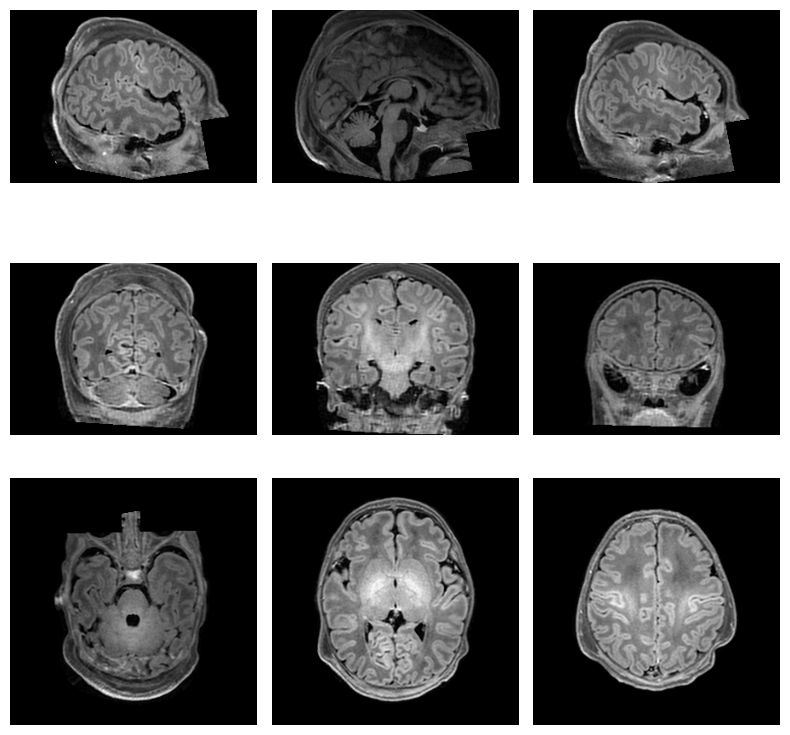

In [4]:
plot = ut.visualize_nifti_depth(t1_scan)
plt.show()

im = nib.load(t1_scan)
# print(im.header)

### Segmentations
Segmentations were done with synthseg BUT current results were done WITHOUT registration

In [5]:
segs = '/home/arnaud/projects/RESEARCH-MRI-analysis/code/volumes/mri_segs/dhcp/noparc'
segs_csvs = '/home/arnaud/projects/RESEARCH-MRI-analysis/code/volumes/mri_segs/dhcp/noparc/csvs'

In [6]:
img = nib.load('/home/arnaud/projects/RESEARCH-MRI-analysis/code/volumes/mri_segs/dhcp/noparc/sub-CC00060XX03_ses-12501_T1w_MNI_synthseg_robust_cpu_frodo.nii.gz')
array_data = img.get_fdata()
array_data.shape

(195, 233, 159)

In [7]:
# build cmap
file = open("FreeSurferColorLUT.txt", "r")
lines = file.readlines()

labels = []
colors = []
uniques = np.unique(array_data).astype(int).tolist()
max_val = max(uniques)
for l in lines[2:]:
    string_parts = l.split()
    if len(string_parts)>0 and string_parts[0] != "#":
        val = int(string_parts[0])
        if val > max_val:
            break
        if val in uniques:
            labels.append(int(string_parts[0]))

            color_string = (','.join(l.split()[2:-1]))
            color_rgba_ = [round(int(x) / 255.0, 2) for x in color_string.split(",")]
            colors.append(to_hex(color_rgba_))


cmap       = ListedColormap(colors)
# build a norm so that each integer goes to one entry of the cmap
bounds = np.concatenate([labels, [labels[-1] + 1]])
norm   = BoundaryNorm(bounds, cmap.N)

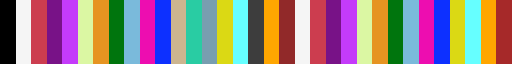

In [8]:
cmap

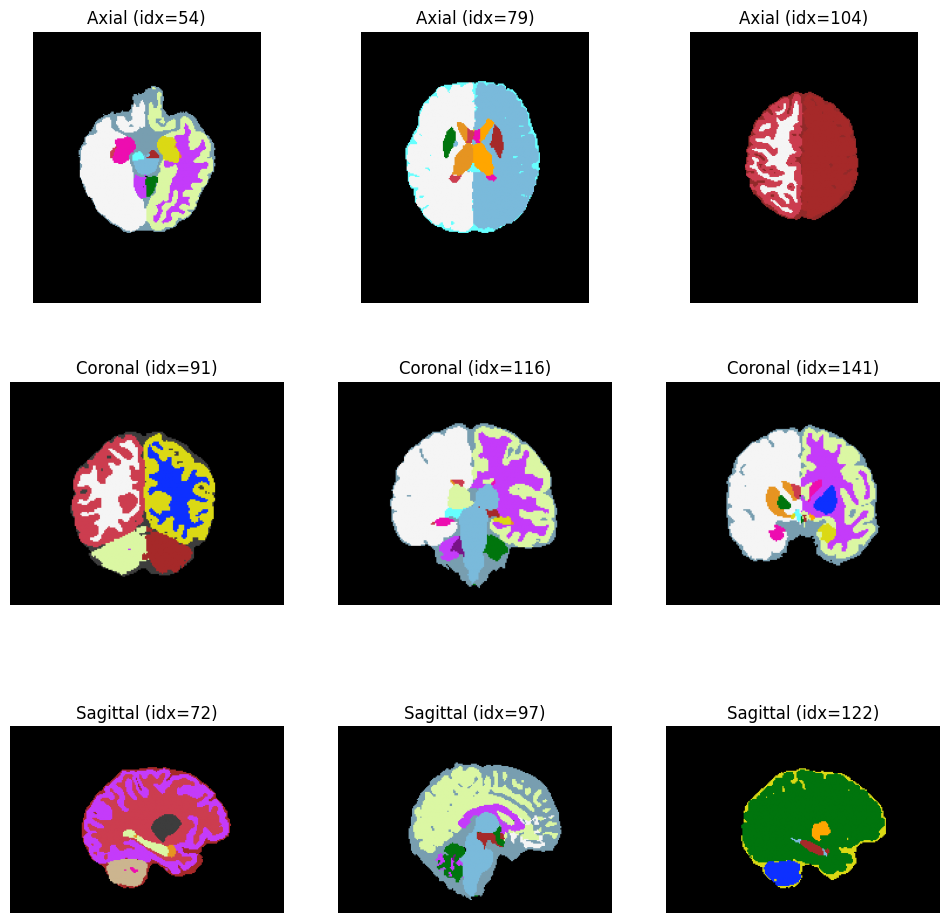

In [10]:
x_mid, y_mid, z_mid = np.array(array_data.shape) // 2

# define offsets (in voxels) around the center
offsets = [-25, 0, +25]

# set up the figure: 3 rows (axial, coronal, sagittal)
fig, axes = plt.subplots(3, len(offsets), figsize=(12, 12))

for row, (orient, center) in enumerate([
    ("axial",   z_mid),
    ("coronal", y_mid),
    ("sagittal",x_mid),
]):
    for col, off in enumerate(offsets):
        idx = center + off
        if orient == "axial":
            sl = array_data[:, :, idx]
        elif orient == "coronal":
            sl = array_data[:, idx, :]
        else:  # sagittal
            sl = array_data[idx, :, :]

        ax = axes[row, col]
        ax.imshow(np.rot90(sl), cmap=cmap)#, norm=norm)
        ax.set_title(f"{orient.capitalize()} (idx={idx})")
        ax.axis("off")

# BOB_idx_lbl['region'] = BOB_idx_lbl['name'].str.replace('^Left-', '', regex=True) \
#                         .str.replace('^Right-', '', regex=True)

# # pick only one entry per lateralized region
# sides       = BOB_idx_lbl[BOB_idx_lbl['name'].str.startswith(('Left-','Right-'))]
# unique_sides = sides.drop_duplicates('region')

# # keep all non-lateral entries intact
# non_sides    = BOB_idx_lbl[~BOB_idx_lbl['name'].str.startswith(('Left-','Right-'))]

# legend_df   = pd.concat([unique_sides, non_sides], ignore_index=True)

# # build legend handles
# handles = [
#     Patch(facecolor=row['color'], edgecolor='black', label=row['region'])
#     for _, row in legend_df.iterrows()
# ]

# # draw the legend
# ncol = 4  
# fig.legend(
#     handles=handles,
#     loc='lower center',
#     ncol=ncol,
#     bbox_to_anchor=(0.5, -0.02),
#     frameon=False
# )
# plt.subplots_adjust(bottom=0.15)
# plt.show()

## FD calculation

In [11]:
# Freesurfer label mapping
index_to_label = {}
with open('FreeSurferColorLUT.txt', 'r') as file:
    for line in file:
        # comments or empty
        if line.startswith('#') or not line.strip():
            continue

        parts = line.split()
        index = int(parts[0])
        label_name = ' '.join(parts[1:-4])
        index_to_label[index] = label_name

Using script #1

In [ ]:
# for win_seg in Path(segs).rglob("*.nii.gz"):
#     # print((win_seg.name).split("_"))
#     shortname = '_'.join((win_seg.name).split("_")[:3])
#     # print(shortname)
#     sess_dir = win_seg.parent / "segmentation_outputs" 
#     sess_dir.mkdir(exist_ok=True)

#     # load the segmentation volume
#     img  = nib.load(str(win_seg))
#     array_data = img.get_fdata().astype(int)

#     # find all non‐zero labels
#     labels = np.unique(array_data)
#     labels = labels[labels != 0]
#     print(f"[{win_seg.stem}] saving masks for labels: {labels}")

#     # write one binary mask per label
#     for lbl in labels:
#         name = index_to_label.get(int(lbl))
#         if not name:
#             print(f"skipping unknown label {lbl}")
#             continue

#         mask     = (array_data == lbl).astype(np.uint8)
#         mask_img = nib.Nifti1Image(mask, img.affine, img.header)
#         mask_fp  = sess_dir /  f"{shortname}_{lbl:03d}_{name}.nii.gz"
#         nib.save(mask_img, str(mask_fp))
#         print(f"wrote {mask_fp.name}")


Steps left : 
 - check dhcp_seg_save
 - FD on all the masks
 - EDA

Using script # 2

In [ ]:
# data_folder = Path("/home/arnaud/projects/RESEARCH-MRI-analysis/code/volumes/mri_segs/dhcp/noparc")

# fd_results = []

# # loop over whole-brain dseg files
# for dseg in data_folder.rglob("*.nii.gz"):
#     shortname = '_'.join((dseg.name).split("_")[:3])
#     # print(dseg.name)
#     print(f"processing {shortname}")
#     participant = (dseg.name).split("_")[0]
#     session = (dseg.name).split("_")[1]

#     ## whole-brain FD
#     fd, (mfs, Mfs), _ = ut.fractal_analysis(str(dseg), verbose=False)
#     fd_results.append({
#         'participant_id': participant,
#         'session_id':    session,
#         'label':         None,
#         'name':          'whole_brain',
#         'fd':            fd,
#         'min_box_size':  mfs,
#         'max_box_size':  Mfs
#     })

#     ## per-mask FD
#     mask_dir = dseg.parent / "segmentation_outputs"
#     print("mask dir", mask_dir)
#     # if not mask_dir.exists():
#     #     print(f" no masks found for {dseg.stem}, skipping masks")
#     #     continue

#     for mask_fp in mask_dir.glob(f"{shortname}*.nii.gz"):
#         lbl = mask_fp.name.split("_")[3]
#         name = mask_fp.name.split("_")[4].split(".")[0]
#         # print(lbl, name)

#         fd, (mfs, Mfs), _ = ut.fractal_analysis(str(mask_fp), verbose=False)
#         fd_results.append({
#             'participant_id': participant,
#             'session_id':    session,
#             'label':         lbl,
#             'name':          name,
#             'fd':            fd,
#             'min_box_size':  mfs,
#             'max_box_size':  Mfs
#         })

#         print(fd_results)
    
#     break

In [12]:
# had some problem running the script, for now only the log were recovered
logfile = open("fd.out", "r")
lines = logfile.readlines()

In [13]:
steps = []
for n, line in enumerate(lines):
    if "processing" in line:
        steps.append(n)

steps

[0,
 35,
 70,
 105,
 140,
 175,
 210,
 245,
 280,
 315,
 350,
 385,
 420,
 455,
 490,
 525,
 560,
 595,
 630,
 665,
 700,
 735,
 770,
 805,
 840,
 875,
 910,
 945,
 980,
 1015,
 1050,
 1085,
 1120,
 1155,
 1190,
 1225,
 1260,
 1294,
 1329,
 1364,
 1399,
 1434,
 1469,
 1504,
 1539,
 1574,
 1609,
 1644,
 1679,
 1714,
 1749,
 1784,
 1819,
 1854,
 1889,
 1924,
 1959,
 1994,
 2029,
 2064,
 2099,
 2134,
 2169,
 2204,
 2239,
 2274,
 2309,
 2344,
 2379,
 2414,
 2449,
 2484,
 2519,
 2554,
 2585,
 2620,
 2655,
 2690,
 2725,
 2760,
 2795,
 2830,
 2865,
 2900,
 2935,
 2970,
 3005,
 3040,
 3075,
 3110,
 3145,
 3180,
 3215,
 3250,
 3285,
 3320,
 3355,
 3390,
 3425,
 3460,
 3495,
 3527,
 3562,
 3597,
 3632,
 3667,
 3702,
 3737,
 3772,
 3807,
 3842,
 3877,
 3912,
 3947,
 3982,
 4014,
 4049,
 4084,
 4119,
 4154,
 4189,
 4224,
 4259,
 4294]

In [14]:
# load the segmentation volume
img  = nib.load("/home/arnaud/projects/RESEARCH-MRI-analysis/code/volumes/mri_segs/dhcp/noparc/sub-CC00907XX16_ses-4230_T2w_MNI_synthseg_robust_cpu_frodo.nii.gz")
array_data = img.get_fdata().astype(int)

# find all non‐zero labels
labels = np.unique(array_data)
labels = labels[labels != 0]

labels

array([ 2,  3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26,
       28, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60])

In [15]:
data_folder = Path("/home/arnaud/projects/RESEARCH-MRI-analysis/code/volumes/mri_segs/dhcp/noparc")

fd_results = []

# loop over whole-brain dseg files
for i, (dseg, line) in enumerate(zip(data_folder.glob("*.nii.gz"), steps[:-1])):
    shortname = '_'.join((dseg.name).split("_")[:3])
    participant = (dseg.name).split("_")[0][4:]
    session = (dseg.name).split("_")[1]
    # print(f"processing {shortname}")
    fd = lines[line+1].split(" ")[-1][:-2]

    fd_results.append({
        'participant_id': participant,
        'session_id':    session,
        'label':         None,
        'name':          'whole_brain',
        'fd':            fd,
    })

    if i < 123 : # last sample is bugged
        for l, lab in zip(range(steps[i]+3, steps[i+1], 1), labels):
            label = int(lab)
            name = index_to_label[label]
            fd_part = lines[l].split(" ")[-1][:-2]

            fd_results.append({
                'participant_id': participant,
                'session_id':    session,
                'label':         int(label),
                'name':          name,
                'fd':            fd_part,
            })
            # print(label, name, fd_part)
print(i)
print(fd_part)

122
1.64


In [16]:
df_fd = pd.DataFrame(fd_results)
df_fd.head()

,participant_id,session_id,label,name,fd
0,CC00409XX13,ses-125600,NaN,whole_brain,2.756
1,CC00409XX13,ses-125600,2.0,Left-Cerebral-White-Matter,2.176
2,CC00409XX13,ses-125600,3.0,Left-Cerebral-Cortex,2.063
3,CC00409XX13,ses-125600,4.0,Left-Lateral-Ventricle,2.016
4,CC00409XX13,ses-125600,5.0,Left-Inf-Lat-Vent,1.452


In [17]:
csvpath = '/home/data/dhcp_mri/sourcedata_orig/participants.tsv'
ds_info = pd.read_csv(csvpath, sep ='\t')
sorted_ds = ds_info.sort_values(by="participant_id", key=natsort_keygen())

sorted_ds

,participant_id,gender,birth_age,birth_weight,singleton
174,CC00058XX09,Male,40.285714,4.135,Single
132,CC00060XX03,Female,40.142857,2.845,Single
479,CC00062XX05,Female,41.285714,4.050,Single
33,CC00063AN06,Female,35.142857,1.950,Multiple
477,CC00065XX08,Male,40.428571,3.400,Single
...,...,...,...,...,...
212,CC00863XX14,Female,41.571429,3.910,Single
317,CC00871XX14,Male,40.285714,4.110,Single
285,CC00879XX22,Female,40.142857,3.650,Single
150,CC00889BN24,Female,33.142857,2.460,Multiple


In [18]:
df_merged = df_fd.merge(sorted_ds, on=['participant_id'], how='left')
df_merged = df_merged[['participant_id', 'session_id', 'label', 'name', 'fd', 'birth_age', 'gender']]
# convert_dict = {'participant_id': str, 'session_id': str, 'label': str, 'name': str, 'fd': float, 'birth_age': float, 'gender': str}
# df_merged = df_merged.astype(convert_dict)
df_merged['fd'] = df_merged['fd'].astype(float)

df_merged.head()


,participant_id,session_id,label,name,fd,birth_age,gender
0,CC00409XX13,ses-125600,NaN,whole_brain,2.756,40.714286,Male
1,CC00409XX13,ses-125600,2.0,Left-Cerebral-White-Matter,2.176,40.714286,Male
2,CC00409XX13,ses-125600,3.0,Left-Cerebral-Cortex,2.063,40.714286,Male
3,CC00409XX13,ses-125600,4.0,Left-Lateral-Ventricle,2.016,40.714286,Male
4,CC00409XX13,ses-125600,5.0,Left-Inf-Lat-Vent,1.452,40.714286,Male


In [19]:
df_merged.to_csv('dhcp_fd_results_123.csv', index=False)

## EDA

In [20]:
n_missing = df_merged['fd'].isna().sum()
print(f"Total missing FD values: {n_missing}")

Total missing FD values: 0


In [21]:
counts = df_merged['name'].value_counts().reset_index()
counts.columns = ['name', 'count']
counts

,name,count
0,whole_brain,123
1,Left-Cerebral-White-Matter,123
2,Left-Cerebral-Cortex,123
3,Left-Lateral-Ventricle,123
4,Left-Inf-Lat-Vent,123
5,Left-Cerebellum-White-Matter,123
6,Left-Cerebellum-Cortex,123
7,Left-Thalamus,123
8,Left-Caudate,123
9,Left-Putamen,123


### Plots

In [22]:
def assign_color(label_name):
    if 'Left' in label_name:
        return '#648FFF'
    elif 'Right' in label_name:
        return '#DC267F'
    elif 'whole_brain' in label_name:
        return '#FFB000'
    else:
        return 'grey'

In [23]:
# Determine sort order by median FD descending
region_order = (
    df_merged.groupby('name')['fd']
      .median()
      .sort_values(ascending=False)
      .index
      .tolist()
)

colors = [assign_color(r) for r in region_order]

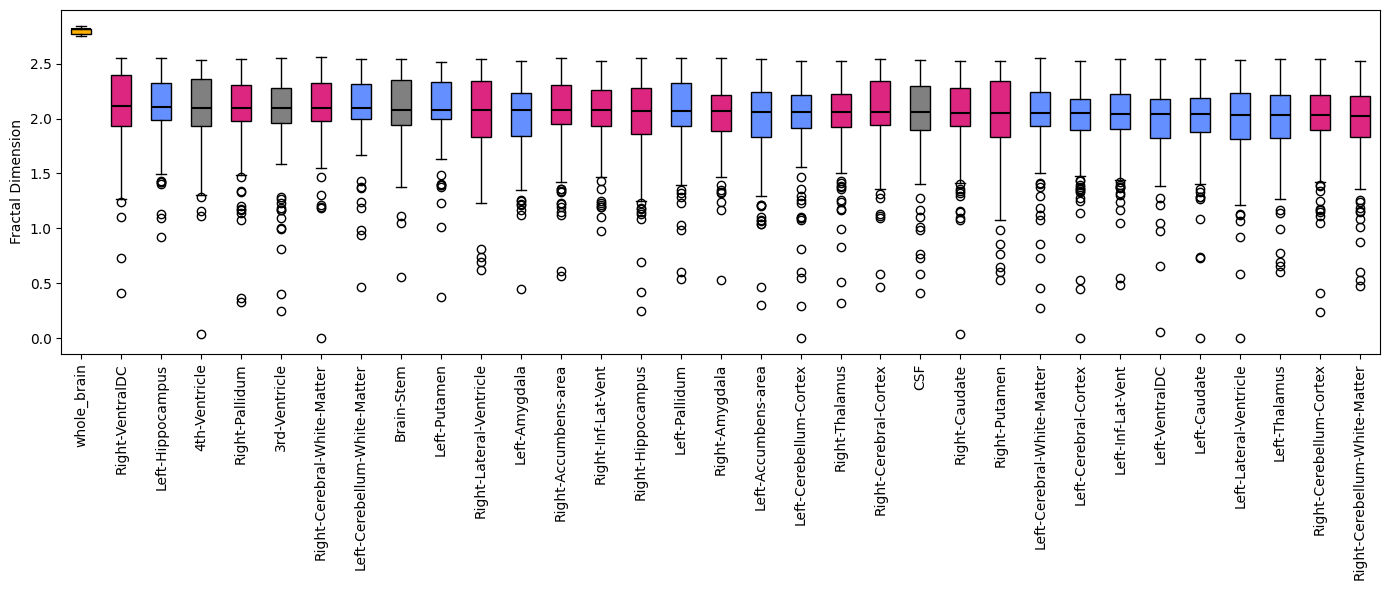

In [24]:
# Prepare data and colors
data_to_plot = [df_merged[df_merged['name'] == r]['fd'] for r in region_order]

plt.figure(figsize=(14, 6))
bp = plt.boxplot(data_to_plot,
                 tick_labels=region_order,
                 patch_artist=True,
                 showfliers=True,
                 medianprops=dict(color='black', linewidth=1.5))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=90)
plt.ylabel("Fractal Dimension")
plt.tight_layout()
plt.show()

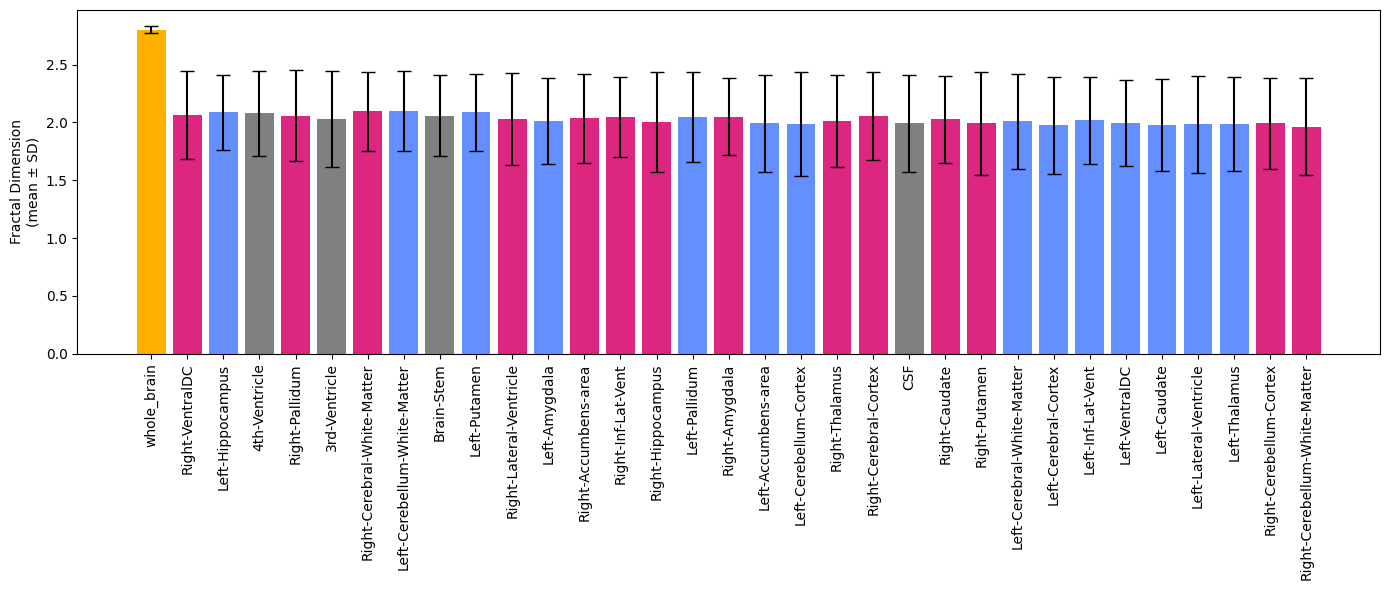

In [25]:
means = []
stds  = []
for r in region_order:
    vals = df_merged.loc[df_merged['name'] == r, 'fd']
    means.append(vals.mean())
    stds.append(vals.std())

x = np.arange(len(region_order))
plt.figure(figsize=(14, 6))
bars = plt.bar(x, means,
               yerr=stds,
               capsize=5,
               color=colors)
plt.xticks(x, region_order, rotation=90)
plt.ylabel("Fractal Dimension\n(mean ± SD)")
plt.tight_layout()
plt.show()

### side comparison

In [26]:
# Helper for Cohen's d (paired)
def cohen_d_paired(x, y):
    diff = x - y
    return diff.mean() / diff.std(ddof=1)

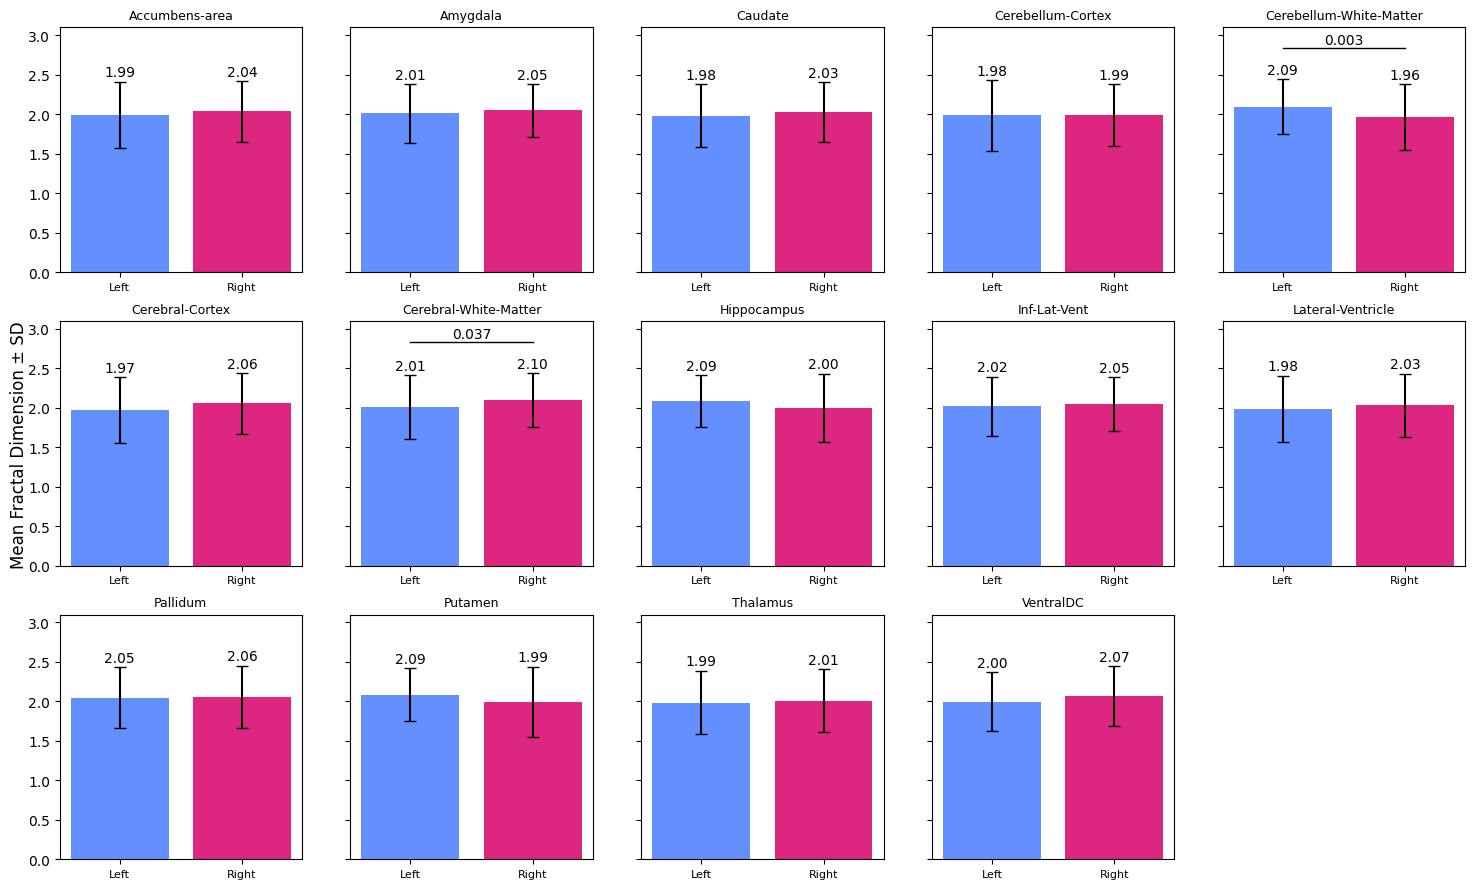

,name,FD (Left),FD (Right),FD (diff),n,p-val,d
0,Accumbens-area,2.02 ± 0.37,2.04 ± 0.38,-0.02 ± 0.49,117,0.595,-0.05
1,Amygdala,2.01 ± 0.37,2.05 ± 0.33,-0.04 ± 0.46,117,0.303,-0.10
2,Caudate,1.98 ± 0.40,2.03 ± 0.37,-0.05 ± 0.53,119,0.353,-0.09
3,Cerebellum-Cortex,1.98 ± 0.45,2.00 ± 0.37,-0.03 ± 0.52,119,0.576,-0.05
4,Cerebellum-White-Matter,2.10 ± 0.34,1.96 ± 0.42,0.14 ± 0.50,119,0.003,0.28
5,Cerebral-Cortex,1.98 ± 0.41,2.06 ± 0.38,-0.08 ± 0.56,119,0.119,-0.14
6,Cerebral-White-Matter,2.01 ± 0.41,2.11 ± 0.29,-0.10 ± 0.50,119,0.037,-0.19
7,Hippocampus,2.09 ± 0.31,2.00 ± 0.42,0.09 ± 0.53,119,0.067,0.17
8,Inf-Lat-Vent,2.02 ± 0.36,2.05 ± 0.34,-0.03 ± 0.52,119,0.525,-0.06
9,Lateral-Ventricle,1.99 ± 0.41,2.03 ± 0.40,-0.04 ± 0.55,119,0.451,-0.07


In [27]:
# Copy and clean
df = df_merged.copy()
df['name'] = df['name'].str.replace(r'\.nii(\.gz)?$', '', regex=True)
df['base_name'] = df['name'].apply(lambda x: re.sub(r'^(Left-|Right-)', '', x))
df['side'] = df['name'].apply(lambda x: 'Left' if x.startswith('Left-') else 'Right')

# Identify true pairs
side_counts = df.groupby('base_name')['side'].nunique()
paired_bases = side_counts[side_counts == 2].index.tolist()
df_paired = df[df['base_name'].isin(paired_bases)]

# Compute statistics table
stats_list = []
for base in paired_bases:
    sub = df_paired[df_paired['base_name'] == base]
    pt = sub.pivot_table(index=['participant_id','session_id'],
                         columns='side', values='fd').dropna()
    left = pt['Left']
    right = pt['Right']
    diff = left - right

    mean_diff = diff.mean()
    sd_diff   = diff.std(ddof=1)
    t_stat, p_val = ttest_rel(left, right)
    d_val = cohen_d_paired(left, right)
    
    stats_list.append({
        'name': base,
        'FD (Left)': f"{left.mean():.2f} ± {left.std(ddof=1):.2f}",
        'FD (Right)': f"{right.mean():.2f} ± {right.std(ddof=1):.2f}",
        'FD (diff)': f"{mean_diff:.2f} ± {sd_diff:.2f}",
        'n': len(diff),
        'p-val': f"{p_val:.3f}",
        'd': f"{d_val:.2f}"
    })

df_stats = pd.DataFrame(stats_list)

# Bar plot of mean ± SD with significance stars
# First, compute mean and sd per side
agg = df_paired.groupby(['base_name','side'])['fd'] \
               .agg(mean='mean', sd='std') \
               .reset_index()

n_pairs = len(paired_bases)
ncols   = 5
nrows   = math.ceil(n_pairs / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3), sharey=True)
axes = axes.flatten()

for ax, base in zip(axes, paired_bases):
    sub = agg[agg['base_name'] == base].set_index('side').loc[['Left','Right']].reset_index()
    x = np.arange(2)
    means = sub['mean'].values
    stds  = sub['sd'].values
    full_names = sub['side'] + '-' + base
    colors = [assign_color(fn) for fn in full_names]
    
    # Plot bars
    ax.bar(x, means, yerr=stds, capsize=4, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels(sub['side'], fontsize=8)
    ax.set_title(base, fontsize=9)
    
    # Annotate mean values
    for xi, m, sd in zip(x, means, stds):
        ax.text(xi, m + sd + 0.03, f"{m:.2f}", ha='center', va='bottom', fontsize=10)
    
    # Significance star
    row = df_stats[df_stats['name'] == base].iloc[0]
    p = float(row['p-val'])

    if p < 0.05:
        # coordinates
        y0 = max(means + stds) + 0.4           # base height of line
        # draw horizontal line 
        ax.plot([x[0], x[1]], [y0, y0], color='black', linewidth=1)
        # add the star centered
        ax.text((x[0]+x[1])/2, y0 + 0.005, f"{p:.3f}",
                ha='center', va='bottom', fontsize=10)

# Turn off extras
for ax in axes[n_pairs:]:
    ax.axis('off')

fig.supylabel("Mean Fractal Dimension ± SD")
plt.setp(axes, ylim=(0, 3.1))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

df_stats
